Instalação de dependências

In [29]:
# !pip install pandas numpy matplotlib scikit-learn xgboost jinja2

Importação dos dados armazenados no banco de dados 
  - Inicialmente utilizando apenas ofertas da Apple
  - Cada captura corresponde a até 10 ofertas, sendo igualmente dividas entre compra e venda 
  - Cada oferta contém preço e volume, além de um tipo associado
  - Ask indica uma oferta de compra
  - Bid indica uma oferta de venda
  - As capturas também acompanham as melhores ofertas negociadas, mas esses dados não nos interessam por hora

In [30]:
import os
import pandas as pd
import numpy as np
import datetime

df = pd.read_parquet('df_final.parquet')

df = df[df['Company'] == 'APPLE INC COM']
df = df[["File_Date", "Price_of_One_Share", "Transaction_type", "Number_of_Shares_Sold", "Time", "Company" ]]


if "Time" in df.columns and pd.api.types.is_timedelta64_dtype(df["Time"]):
    df["Time"] = df["Time"].apply(
        lambda x: (datetime.datetime.min + x).time() if pd.notnull(x) else None
    )
    
df.head(10) #print

,File_Date,Price_of_One_Share,Transaction_type,Number_of_Shares_Sold,Time,Company
0,2024-07-10 12:21:57,230.90,asks,1.0,11:21:47,APPLE INC COM
1,2024-07-10 12:21:57,230.94,asks,1.0,11:21:49,APPLE INC COM
2,2024-07-10 12:21:57,230.92,bids,7.0,11:21:40,APPLE INC COM
3,2024-07-10 12:21:57,230.92,bids,5.0,11:21:40,APPLE INC COM
4,2024-07-10 12:21:57,230.92,bids,3.0,11:21:40,APPLE INC COM
5,2024-07-10 12:21:57,230.90,asks,400.0,11:21:47,APPLE INC COM
6,2024-07-10 12:21:57,230.91,bids,1.0,11:21:43,APPLE INC COM
7,2024-07-10 12:21:57,230.91,asks,52.0,11:21:47,APPLE INC COM
8,2024-07-10 12:21:57,230.91,asks,48.0,11:21:47,APPLE INC COM
9,2024-07-10 12:21:57,230.92,bids,1.0,11:21:40,APPLE INC COM


In [31]:
df["Company"] = df["Company"].str.split(" ").str[0]
df.head(10) #print

,File_Date,Price_of_One_Share,Transaction_type,Number_of_Shares_Sold,Time,Company
0,2024-07-10 12:21:57,230.90,asks,1.0,11:21:47,APPLE
1,2024-07-10 12:21:57,230.94,asks,1.0,11:21:49,APPLE
2,2024-07-10 12:21:57,230.92,bids,7.0,11:21:40,APPLE
3,2024-07-10 12:21:57,230.92,bids,5.0,11:21:40,APPLE
4,2024-07-10 12:21:57,230.92,bids,3.0,11:21:40,APPLE
5,2024-07-10 12:21:57,230.90,asks,400.0,11:21:47,APPLE
6,2024-07-10 12:21:57,230.91,bids,1.0,11:21:43,APPLE
7,2024-07-10 12:21:57,230.91,asks,52.0,11:21:47,APPLE
8,2024-07-10 12:21:57,230.91,asks,48.0,11:21:47,APPLE
9,2024-07-10 12:21:57,230.92,bids,1.0,11:21:40,APPLE


Renomeando as colunas
  - Os nomes simples facilitarão na hora de aplicar a janela deslizante

In [32]:
df = df.rename(columns={
    'File_Date': 'Fdate', 
    'Price_of_One_Share': 'P', 
    'Transaction_type': 'Type', 
    'Number_of_Shares_Sold': 'S',
    'Time': 'T'
})
df #print

,Fdate,P,Type,S,T,Company
0,2024-07-10 12:21:57,230.90,asks,1.0,11:21:47,APPLE
1,2024-07-10 12:21:57,230.94,asks,1.0,11:21:49,APPLE
2,2024-07-10 12:21:57,230.92,bids,7.0,11:21:40,APPLE
3,2024-07-10 12:21:57,230.92,bids,5.0,11:21:40,APPLE
4,2024-07-10 12:21:57,230.92,bids,3.0,11:21:40,APPLE
...,...,...,...,...,...,...
5751305,2024-10-18 18:00:02,235.03,bids,7.0,16:56:55,APPLE
5751306,2024-10-18 18:00:02,235.03,bids,1.0,16:56:43,APPLE
5751307,2024-10-18 18:00:02,235.03,bids,4.0,16:53:28,APPLE
5751308,2024-10-18 18:00:02,235.04,bids,1.0,16:52:12,APPLE


Eliminando capturas sem dados

In [33]:
df = df.dropna().reset_index(drop=True)
df #print

,Fdate,P,Type,S,T,Company
0,2024-07-10 12:21:57,230.90,asks,1.0,11:21:47,APPLE
1,2024-07-10 12:21:57,230.94,asks,1.0,11:21:49,APPLE
2,2024-07-10 12:21:57,230.92,bids,7.0,11:21:40,APPLE
3,2024-07-10 12:21:57,230.92,bids,5.0,11:21:40,APPLE
4,2024-07-10 12:21:57,230.92,bids,3.0,11:21:40,APPLE
...,...,...,...,...,...,...
302555,2024-10-18 18:00:02,235.03,bids,7.0,16:56:55,APPLE
302556,2024-10-18 18:00:02,235.03,bids,1.0,16:56:43,APPLE
302557,2024-10-18 18:00:02,235.03,bids,4.0,16:53:28,APPLE
302558,2024-10-18 18:00:02,235.04,bids,1.0,16:52:12,APPLE


Realizando ordenação por data de captura e tipo de oferta
  - Isso é essencial para agrupar posteriormente esses dados

In [34]:
# df = df.sort_values(by=['Fdate', 'Type'], ascending=[True, True]).reset_index(drop=True)
# df.head(11) #print

Unindo o horário de capturas iniciadas e finalizadas em momentos diferentes 
  - Todas as ofertas armazenarão o horário da captura, mesmo que tenham sido armazenadas segundos depois
  - A duração considerada é de até 5 segundos
  - A partir da duração considerada, qualquer oferta será associada a uma nova captura

In [35]:
df2 = df.copy()
threshold = 5 #segundos

original_dates = df2['Fdate'].copy()

df2['Fdate'] = pd.to_datetime(df2['Fdate'])
# Cria-se uma coluna "group" que identifica ofertas capturadas dentro de um intervalo de 5 segundos
# cumsum() garante que cada grupo tenha um valor único
df2['group'] = (df2['Fdate'] - df2['Fdate'].shift().fillna(df2['Fdate'].min())).dt.total_seconds().gt(threshold).cumsum()
# Todas as ofertas dentro de um mesmo grupo recebem a data da primeira oferta
df2['Fdate'] = df2.groupby('group').transform('first')['Fdate']

original_dates_dt = pd.to_datetime(original_dates)
modified_rows = (original_dates_dt != df2['Fdate']).sum()
print(f"Número de linhas modificadas: {modified_rows}")
print(f"Total de linhas: {len(df2)}")
print(f"Porcentagem de linhas modificadas: {modified_rows/len(df2)*100:.2f}%")

df2 = df2.drop('group', axis=1)
del original_dates, original_dates_dt, modified_rows

df2 #print

Número de linhas modificadas: 690
Total de linhas: 302560
Porcentagem de linhas modificadas: 0.23%


,Fdate,P,Type,S,T,Company
0,2024-07-10 12:21:57,230.90,asks,1.0,11:21:47,APPLE
1,2024-07-10 12:21:57,230.94,asks,1.0,11:21:49,APPLE
2,2024-07-10 12:21:57,230.92,bids,7.0,11:21:40,APPLE
3,2024-07-10 12:21:57,230.92,bids,5.0,11:21:40,APPLE
4,2024-07-10 12:21:57,230.92,bids,3.0,11:21:40,APPLE
...,...,...,...,...,...,...
302555,2024-10-18 18:00:02,235.03,bids,7.0,16:56:55,APPLE
302556,2024-10-18 18:00:02,235.03,bids,1.0,16:56:43,APPLE
302557,2024-10-18 18:00:02,235.03,bids,4.0,16:53:28,APPLE
302558,2024-10-18 18:00:02,235.04,bids,1.0,16:52:12,APPLE


Reordenam-se as transações para facilitar o treinamento do modelo

In [36]:
df2 = df2.set_index(['Fdate'])
df2['T'] = pd.to_datetime(df2['T'], format='%H:%M:%S').dt.time
df2 = df2.sort_values(by=['Fdate', 'T'], ascending=[True, False]).reset_index()

df2.head(15) #print

# if not pd.api.types.is_datetime64_any_dtype(df2['Fdate']):
#     df2['Fdate'] = pd.to_datetime(df2['Fdate'])
# mask_valid_time = df2['T'].apply(lambda x: isinstance(x, str) and len(x.split(':')) == 3)
# df2 = df2[mask_valid_time].copy()
# try:
#     df2['T'] = pd.to_datetime(df2['T'], format='%H:%M:%S').dt.time
# except Exception as e:
#     print(f"Time conversion error: {e}")
# df2 = df2.set_index(['Fdate'])
# df2 = df2.sort_values(by=['Fdate', 'T'], ascending=[True, False]).reset_index()
# print(df2.head(15)) #print

,Fdate,P,Type,S,T,Company
0,2024-07-10 12:21:57,230.94,asks,1.0,11:21:49,APPLE
1,2024-07-10 12:21:57,230.90,asks,1.0,11:21:47,APPLE
2,2024-07-10 12:21:57,230.90,asks,400.0,11:21:47,APPLE
3,2024-07-10 12:21:57,230.91,asks,52.0,11:21:47,APPLE
4,2024-07-10 12:21:57,230.91,asks,48.0,11:21:47,APPLE
5,2024-07-10 12:21:57,230.91,bids,1.0,11:21:43,APPLE
6,2024-07-10 12:21:57,230.92,bids,7.0,11:21:40,APPLE
7,2024-07-10 12:21:57,230.92,bids,5.0,11:21:40,APPLE
8,2024-07-10 12:21:57,230.92,bids,3.0,11:21:40,APPLE
9,2024-07-10 12:21:57,230.92,bids,1.0,11:21:40,APPLE


In [37]:
df2 = df2.drop('T', axis=1)

Para que as capturas sejam agrupadas por horário, precisamos ter diferentes níveis para cada tipo de oferta.
  - Haverão 5 níveis de ask e 5 níveis de bid por captura
  - Como cada nível terá um valor único na coluna "Type", poderemos usá-los como colunas
  - Teremos então preços e shares para cada nível, totalizando 20 colunas por captura
  - Os indivíduos do novo dataframe representarão cada captura

In [38]:
df2['N'] = df2.groupby(['Fdate', 'Type']).cumcount() + 1
df2['Type'] = df2['Type'].str[0] + '_' + df2['N'].astype('str')

df2 = df2.drop('N', axis=1)
print(df2.head(5)) #print
print(df2.tail(5)) #print

                Fdate       P Type      S Company
0 2024-07-10 12:21:57  230.94  a_1    1.0   APPLE
1 2024-07-10 12:21:57  230.90  a_2    1.0   APPLE
2 2024-07-10 12:21:57  230.90  a_3  400.0   APPLE
3 2024-07-10 12:21:57  230.91  a_4   52.0   APPLE
4 2024-07-10 12:21:57  230.91  a_5   48.0   APPLE
                     Fdate       P Type     S Company
302555 2024-10-18 18:00:02  235.03  b_1   7.0   APPLE
302556 2024-10-18 18:00:02  235.03  b_2   1.0   APPLE
302557 2024-10-18 18:00:02  235.03  b_3   4.0   APPLE
302558 2024-10-18 18:00:02  235.04  b_4   1.0   APPLE
302559 2024-10-18 18:00:02  235.04  b_5  61.0   APPLE


Análise estatística descritiva dos dados processados

In [39]:
df2.describe().T #print

,count,mean,min,25%,50%,75%,max,std
Fdate,302560,2024-08-30 22:00:31.888914688,2024-07-10 12:21:57,2024-08-02 10:59:45.249999872,2024-08-30 17:22:12.500000,2024-09-26 14:18:45.249999872,2024-10-18 18:00:02,NaN
P,302560.0,224.64853,197.13,220.93,225.45,228.31625,237.33,5.903355
S,302560.0,62.850426,1.0,8.0,33.0,100.0,25707.0,129.419129


In [40]:
# import pandas as pd

# # Garante que a coluna de data está no formato datetime
# if not pd.api.types.is_datetime64_any_dtype(df_monthly['Fdate']):
#     df_monthly['Fdate'] = pd.to_datetime(df_monthly['Fdate'])

# # Cria coluna de ano-mês
# if 'year_month' not in df_monthly.columns:
#     df_monthly['year_month'] = df_monthly['Fdate'].dt.to_period('M')

# for period, group in df_monthly.groupby('year_month'):
#     first_day = group['Fdate'].min().date()
#     last_day = group['Fdate'].max().date()
#     print(f"\nMês: {period}")
#     print(f"Primeiro dia: {first_day}")
#     print(f"Último dia: {last_day}")
#     display(group.describe().T)
#     print("-"*60)


In [41]:
df2 = df2.pivot(columns='Type', index='Fdate', values=['P', 'S'])
df2 #print


P                                                    \
Type                    a_1      a_2      a_3     a_4     a_5     b_1     b_2   
Fdate                                                                           
2024-07-10 12:21:57  230.94  230.900  230.900  230.91  230.91  230.91  230.92   
2024-07-10 12:23:02  230.87  230.870  230.870  230.87  230.88  230.88  230.88   
2024-07-10 12:25:41  230.85  230.850  230.850  230.85  230.85  230.85  230.85   
2024-07-10 12:26:37  230.94  230.930  230.935  230.96  230.96  230.91  230.91   
2024-07-10 12:27:32  230.95  230.935  230.920  230.92  230.93  230.91  230.91   
...                     ...      ...      ...     ...     ...     ...     ...   
2024-10-18 17:56:19  235.03  235.040  235.040  235.04  235.04  235.04  235.04   
2024-10-18 17:57:15  235.03  235.030  235.030  235.03  235.03  235.04  235.04   
2024-10-18 17:58:11  235.03  235.030  235.030  235.03  235.03  235.03  235.03   
2024-10-18 17:59:06  235.02  235.030  235.030  235.03  235.03  235.03  235.03   
2024-10-18 18:00:02  235.02  235.030  235.030  235.03  235.03  235.03  235.03   

                                                 S                             \
Type                    b_3     b_4     b_5    a_1    a_2    a_3    a_4   a_5   
Fdate                                                                           
2024-07-10 12:21:57  230.92  230.92  230.92    1.0    1.0  400.0   52.0  48.0   
2024-07-10 12:23:02  230.88  230.88  230.88  500.0   10.0  690.0  610.0  52.0   
2024-07-10 12:25:41  230.85  230.85  230.87  100.0  100.0  100.0   73.0  27.0   
2024-07-10 12:26:37  230.92  230.95  230.93   10.0    1.0    3.0  100.0   2.0   
2024-07-10 12:27:32  230.91  230.91  230.91    1.0    2.0  100.0    5.0  10.0   
...                     ...     ...     ...    ...    ...    ...    ...   ...   
2024-10-18 17:56:19  235.04  235.04  235.04    4.0    1.0   61.0    2.0  60.0   
2024-10-18 17:57:15  235.04  235.04  235.04    1.0    1.0    7.0    1.0   4.0   
2024-10-18 17:58:11  235.04  235.04  235.04   19.0    1.0    1.0    1.0   7.0   
2024-10-18 17:59:06  235.03  235.04  235.04    1.0   19.0    1.0    1.0   1.0   
2024-10-18 18:00:02  235.03  235.04  235.04    1.0   19.0    1.0    1.0   1.0   

                                                        
Type                  b_1    b_2    b_3    b_4     b_5  
Fdate                                                   
2024-07-10 12:21:57   1.0    7.0    5.0    3.0     1.0  
2024-07-10 12:23:02  25.0   23.0    3.0  100.0   100.0  
2024-07-10 12:25:41  59.0  100.0   34.0  100.0   100.0  
2024-07-10 12:26:37   6.0   21.0   44.0   32.0     4.0  
2024-07-10 12:27:32  50.0    1.0   92.0  100.0   100.0  
...                   ...    ...    ...    ...     ...  
2024-10-18 17:56:19   1.0   50.0  100.0   37.0  1089.0  
2024-10-18 17:57:15   1.0   61.0    2.0   60.0     1.0  
2024-10-18 17:58:11   1.0    4.0    1.0   61.0     2.0  
2024-10-18 17:59:06   7.0    1.0    4.0    1.0    61.0  
2024-10-18 18:00:02   7.0    1.0    4.0    1.0    61.0  

[30256 rows x 20 columns]

Eliminando capturas duplicadas

O scrapper continua funcionando após fechamento da bolsa, o que provoca capturas novas com os mesmos dados repetidamente, isso gera um viés no modelo.
Para corrigir o problema, eliminamos capturas duplicadas

In [42]:
df2 = df2.drop_duplicates()
print(len(df2)) #print

28575


Verificando que não há informações faltantes.<br>
Capturas com menos ofertas possuiriam valores faltantes (NaN), o que não ocorre.  

In [43]:
df2[df2.isna().any(axis=1)] #print

Empty DataFrame
Columns: [(P, a_1), (P, a_2), (P, a_3), (P, a_4), (P, a_5), (P, b_1), (P, b_2), (P, b_3), (P, b_4), (P, b_5), (S, a_1), (S, a_2), (S, a_3), (S, a_4), (S, a_5), (S, b_1), (S, b_2), (S, b_3), (S, b_4), (S, b_5)]
Index: []

Os multi-índices são planificados para facilitar a manipulação dos dados

In [44]:
df2.columns = [''.join(col) for col in df2.columns]
df2.head(10) #print

,Pa_1,Pa_2,Pa_3,Pa_4,Pa_5,Pb_1,Pb_2,Pb_3,Pb_4,Pb_5,Sa_1,Sa_2,Sa_3,Sa_4,Sa_5,Sb_1,Sb_2,Sb_3,Sb_4,Sb_5
Fdate,,,,,,,,,,,,,,,,,,,,
2024-07-10 12:21:57,230.94,230.900,230.900,230.91,230.91,230.91,230.92,230.92,230.92,230.92,1.0,1.0,400.0,52.0,48.0,1.0,7.0,5.0,3.0,1.0
2024-07-10 12:23:02,230.87,230.870,230.870,230.87,230.88,230.88,230.88,230.88,230.88,230.88,500.0,10.0,690.0,610.0,52.0,25.0,23.0,3.0,100.0,100.0
2024-07-10 12:25:41,230.85,230.850,230.850,230.85,230.85,230.85,230.85,230.85,230.85,230.87,100.0,100.0,100.0,73.0,27.0,59.0,100.0,34.0,100.0,100.0
2024-07-10 12:26:37,230.94,230.930,230.935,230.96,230.96,230.91,230.91,230.92,230.95,230.93,10.0,1.0,3.0,100.0,2.0,6.0,21.0,44.0,32.0,4.0
2024-07-10 12:27:32,230.95,230.935,230.920,230.92,230.93,230.91,230.91,230.91,230.91,230.91,1.0,2.0,100.0,5.0,10.0,50.0,1.0,92.0,100.0,100.0
2024-07-10 12:28:28,231.00,231.000,230.945,230.96,230.97,230.97,230.97,230.98,231.01,231.01,100.0,100.0,1.0,100.0,100.0,200.0,200.0,10.0,200.0,2.0
2024-07-10 12:29:25,231.00,230.980,230.980,230.97,230.99,230.98,230.98,230.98,230.97,230.97,100.0,100.0,4.0,100.0,100.0,7.0,200.0,5.0,88.0,12.0
2024-07-10 12:30:26,231.04,231.050,231.050,231.05,231.06,231.05,231.05,231.06,231.06,231.06,100.0,41.0,16.0,100.0,26.0,100.0,10.0,10.0,10.0,90.0
2024-07-10 12:31:22,231.25,231.210,231.210,231.20,231.20,231.20,231.22,231.25,231.25,231.24,200.0,10.0,12.0,3.0,100.0,100.0,100.0,19.0,74.0,100.0


In [45]:
df2.to_csv('df_20_dados_fdate.csv')
print(len(df2)) #print

28575


Finalmente, aplica-se a janela deslizante nas capturas de ofertas
  - Cada linha do dataframe resultante contém X observações de ofertas anteriores, a observação atual e a próxima observação
  - A janela será igual a X + 1 = 3, de forma que 1 é logicamente o tamanho mínimo da janela

In [46]:
def get_renamed_df(df, i):
    df.columns = [f'{col}-{i}' for col in df.columns]
    return df

window = 3
df_lag = get_renamed_df(df2.copy(), 0)

for i in range(1, window):
  temp_df = get_renamed_df(df2.copy().shift(i), i)
  df_lag = pd.concat([df_lag, temp_df], axis=1)

temp_df = df2.copy().shift(-1)
df_lag = pd.concat([df_lag, temp_df], axis=1)

df_lag = df_lag.dropna()
df_lag.columns #print

Index(['Pa_1-0', 'Pa_2-0', 'Pa_3-0', 'Pa_4-0', 'Pa_5-0', 'Pb_1-0', 'Pb_2-0',
       'Pb_3-0', 'Pb_4-0', 'Pb_5-0', 'Sa_1-0', 'Sa_2-0', 'Sa_3-0', 'Sa_4-0',
       'Sa_5-0', 'Sb_1-0', 'Sb_2-0', 'Sb_3-0', 'Sb_4-0', 'Sb_5-0', 'Pa_1-1',
       'Pa_2-1', 'Pa_3-1', 'Pa_4-1', 'Pa_5-1', 'Pb_1-1', 'Pb_2-1', 'Pb_3-1',
       'Pb_4-1', 'Pb_5-1', 'Sa_1-1', 'Sa_2-1', 'Sa_3-1', 'Sa_4-1', 'Sa_5-1',
       'Sb_1-1', 'Sb_2-1', 'Sb_3-1', 'Sb_4-1', 'Sb_5-1', 'Pa_1-2', 'Pa_2-2',
       'Pa_3-2', 'Pa_4-2', 'Pa_5-2', 'Pb_1-2', 'Pb_2-2', 'Pb_3-2', 'Pb_4-2',
       'Pb_5-2', 'Sa_1-2', 'Sa_2-2', 'Sa_3-2', 'Sa_4-2', 'Sa_5-2', 'Sb_1-2',
       'Sb_2-2', 'Sb_3-2', 'Sb_4-2', 'Sb_5-2', 'Pa_1', 'Pa_2', 'Pa_3', 'Pa_4',
       'Pa_5', 'Pb_1', 'Pb_2', 'Pb_3', 'Pb_4', 'Pb_5', 'Sa_1', 'Sa_2', 'Sa_3',
       'Sa_4', 'Sa_5', 'Sb_1', 'Sb_2', 'Sb_3', 'Sb_4', 'Sb_5'],
      dtype='object')

In [47]:
# count df lag
print(df_lag.count(axis=1).value_counts()) #print

80    28572
Name: count, dtype: int64


In [48]:
# Divisão por número absoluto de dias (90% treino, 10% teste)
unique_days = df_lag.index.normalize().unique()
unique_days = pd.Index(sorted(unique_days))
n_days = len(unique_days)
print(f"Número de dias únicos: {n_days}")

cut_idx = int(n_days * 0.9)

train_days = unique_days[:cut_idx]
test_days = unique_days[cut_idx:]

print(f"Dias de treino: {len(train_days)} ({len(train_days)/n_days*100:.1f}%)")
print(f"Dias de teste: {len(test_days)} ({len(test_days)/n_days*100:.1f}%)")

# Create train and test sets from the original df_lag
df_lag_train = df_lag[df_lag.index.normalize().isin(train_days)].copy()
df_lag_test = df_lag[df_lag.index.normalize().isin(test_days)].copy()

print(f"Registros em df_lag_treino: {len(df_lag_train)}")
print(f"Registros em df_lag_test: {len(df_lag_test)}")

df_lag_test.to_csv('df_20_dados_fdate_test.csv')
df_lag = df_lag_train

Número de dias únicos: 64
Dias de treino: 57 (89.1%)
Dias de teste: 7 (10.9%)
Registros em df_lag_treino: 25523
Registros em df_lag_test: 3049


In [49]:
# n_total = len(df_lag)
# print(f"Total de registros em df2: {n_total}")

# cut_idx = int(n_total * 0.9)

# df_lag_last20 = df_lag.iloc[cut_idx:].copy()
# df_lag = df_lag.iloc[:cut_idx].copy()

# print(f"Registros no novo df_lag: {len(df_lag)}")
# print(f"Registros em df_lag_last20: {len(df_lag_last20)}")

# df_lag_last20.to_csv('df_20_dados_fdate_test.csv')

In [50]:
# count df_lag rows
print(len(df_lag.index)) #print

25523


In [51]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# train_size = int(len(df_lag)*0.8)
# train = df_lag[:train_size]
# test = df_lag[train_size:]

target_variables = [col for col in df_lag.columns if len(col) == 4]
features = [col for col in df_lag.columns if col not in target_variables]

X_train = df_lag[features]
y_train = df_lag[target_variables]
X_test = df_lag_test[features]
y_test = df_lag_test[target_variables]

model = xgb.XGBRegressor(
    alpha=1.8727005942368125,
    colsample_bytree=0.9753571532049581,
    gamma=2.1959818254342154,
    lambda_=2.993292420985183,
    learning_rate=0.039643541684062936,
    max_depth=5,
    min_child_weight=7,
    n_estimators=380,
    subsample=0.7296244459829335,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred, multioutput='raw_values')
mape = mean_absolute_percentage_error(y_test, y_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))


/home/ge28/Desktop/Python/trab_final/python-connector/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:05:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "lambda_" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [52]:
results = pd.DataFrame({
    'MAE': mae,
    'MAPE': mape,
    'MSE': mse,
    'RMSE': rmse,
    'R2': r2,
}, index=y_test.columns)

results #print

,MAE,MAPE,MSE,RMSE,R2
Pa_1,0.110412,0.000474,0.049298,0.222031,0.993010
Pa_2,0.110377,0.000474,0.049312,0.222064,0.993008
Pa_3,0.109936,0.000472,0.049537,0.222569,0.992978
Pa_4,0.109857,0.000472,0.049107,0.221601,0.993039
Pa_5,0.109885,0.000472,0.049620,0.222755,0.992967
Pb_1,0.110044,0.000473,0.049959,0.223516,0.992919
Pb_2,0.109027,0.000468,0.049414,0.222293,0.992997
Pb_3,0.110021,0.000473,0.049998,0.223602,0.992913
Pb_4,0.109710,0.000471,0.049571,0.222646,0.992972
Pb_5,0.110366,0.000474,0.049820,0.223203,0.992938


In [53]:
results.to_csv('results_xb.csv')
print(results.to_latex()) #print

\begin{tabular}{lrrrrr}
\toprule
 & MAE & MAPE & MSE & RMSE & R2 \\
\midrule
Pa_1 & 0.110412 & 0.000474 & 0.049298 & 0.222031 & 0.993010 \\
Pa_2 & 0.110377 & 0.000474 & 0.049312 & 0.222064 & 0.993008 \\
Pa_3 & 0.109936 & 0.000472 & 0.049537 & 0.222569 & 0.992978 \\
Pa_4 & 0.109857 & 0.000472 & 0.049107 & 0.221601 & 0.993039 \\
Pa_5 & 0.109885 & 0.000472 & 0.049620 & 0.222755 & 0.992967 \\
Pb_1 & 0.110044 & 0.000473 & 0.049959 & 0.223516 & 0.992919 \\
Pb_2 & 0.109027 & 0.000468 & 0.049414 & 0.222293 & 0.992997 \\
Pb_3 & 0.110021 & 0.000473 & 0.049998 & 0.223602 & 0.992913 \\
Pb_4 & 0.109710 & 0.000471 & 0.049571 & 0.222646 & 0.992972 \\
Pb_5 & 0.110366 & 0.000474 & 0.049820 & 0.223203 & 0.992938 \\
Sa_1 & 51.353714 & 11.109028 & 6834.101562 & 82.668625 & -0.072582 \\
Sa_2 & 53.068649 & 10.033704 & 8632.478516 & 92.911133 & -0.066043 \\
Sa_3 & 54.773895 & 10.033730 & 18292.908203 & 135.251282 & -0.017790 \\
Sa_4 & 56.784485 & 9.505681 & 13126.743164 & 114.571999 & -0.028957 \\
Sa_5 & 61.

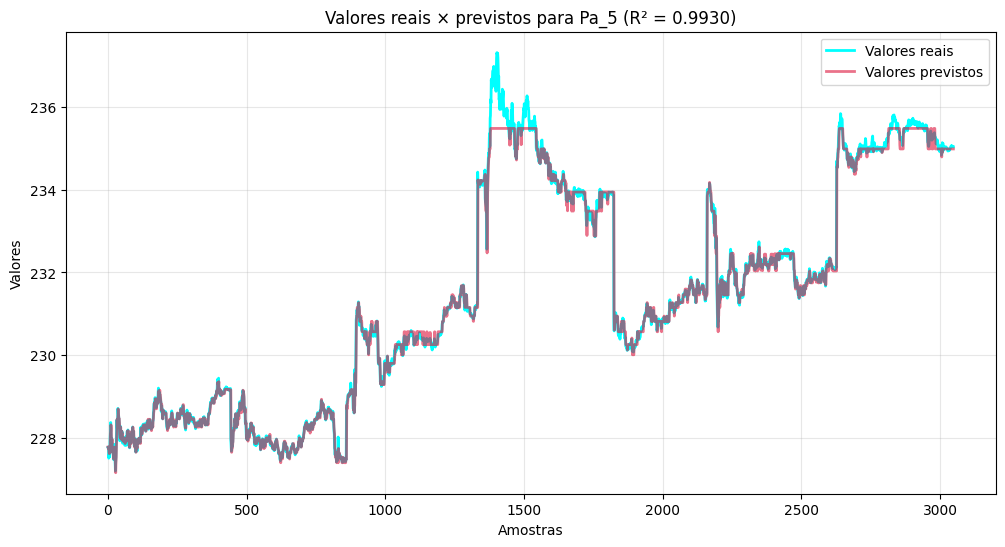

Estatísticas para Pa_5:
  R²: 0.9930
  MAE: 0.1099
  RMSE: 0.2228
  MAPE: 0.0005


In [54]:
import matplotlib.pyplot as plt

def plot_graph(column):
    x = range(len(y_test))
    plt.figure(figsize=(12, 6))
    plt.tight_layout()

    pred_index = y_test.columns.get_loc(column)
    
    plt.plot(x, y_test[column], label='Valores reais', alpha=1, lw=2, color='cyan')
    plt.plot(x, y_pred[:, pred_index], label='Valores previstos', alpha=0.6, lw=2, color='crimson')
    
    r2_single = r2_score(y_test[column], y_pred[:, pred_index])
    plt.title(f'Valores reais × previstos para {column} (R² = {r2_single:.4f})')

    plt.xlabel('Amostras')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Estatísticas para {column}:")
    print(f"  R²: {r2_single:.4f}")
    print(f"  MAE: {mae[pred_index]:.4f}")
    print(f"  RMSE: {rmse[pred_index]:.4f}")
    print(f"  MAPE: {mape[pred_index]:.4f}")

plot_graph('Pa_5') #print

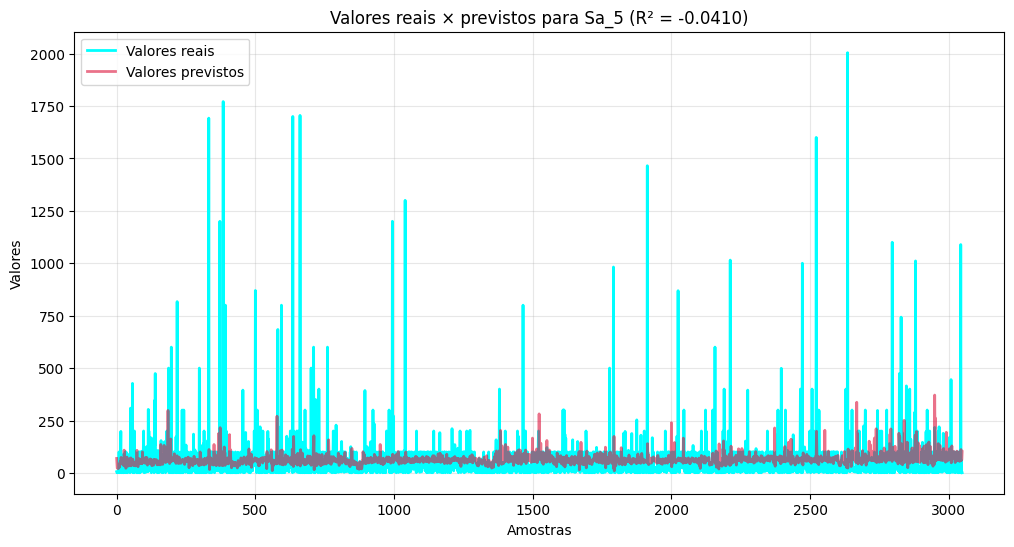

Estatísticas para Sa_5:
  R²: -0.0410
  MAE: 61.6774
  RMSE: 126.5927
  MAPE: 10.1977


In [55]:
plot_graph('Sa_5') #print

In [56]:
import pickle
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)